In [2]:
from google.colab import drive
import torch
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import time
import os
import zipfile

drive.mount('/content/drive')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

ZIP_PATH = '/content/drive/MyDrive/sample_computer_vision.zip'
EXTRACT_PATH = '/content/temp_vision_data'

if not os.path.exists(EXTRACT_PATH):
    print(f"Extracting data from {ZIP_PATH}...")
    try:
        with zipfile.ZipFile(ZIP_PATH, 'r') as zip_ref:
            zip_ref.extractall(EXTRACT_PATH)
        print("Extraction complete.")
    except FileNotFoundError:
        print("FATAL ERROR: ZIP file not found. Check the ZIP_PATH.")
        raise
else:
    print("Data already extracted.")

NORM_MEAN = [0.485, 0.456, 0.406]
NORM_STD = [0.229, 0.224, 0.225]

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(NORM_MEAN, NORM_STD)
    ]),
}

data_dir = os.path.join(EXTRACT_PATH, 'sample_computer_vision')

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

print(f"Classes: {class_names}")
print(f"Train size: {dataset_sizes['train']}, Validation size: {dataset_sizes['val']}")

Mounted at /content/drive
Device: cuda
Extracting data from /content/drive/MyDrive/sample_computer_vision.zip...
Extraction complete.
Classes: ['cats', 'dogs']
Train size: 1002, Validation size: 200


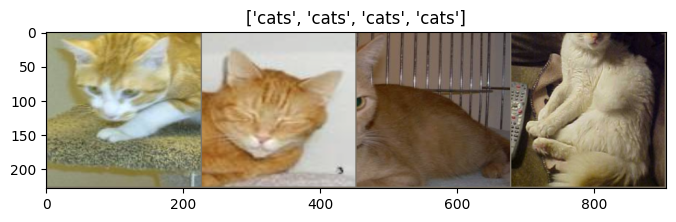

In [3]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))

    mean = np.array(NORM_MEAN)
    std = np.array(NORM_STD)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

inputs, classes = next(iter(dataloaders['train']))

out = torchvision.utils.make_grid(inputs)

plt.figure(figsize=(8, 8))
imshow(out, title=[class_names[x] for x in classes])

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 204MB/s]


Epoch 1/15
----------


/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


train Loss: 0.5242 Acc: 0.7705
val Loss: 0.1631 Acc: 0.9300

Epoch 2/15
----------
train Loss: 0.5206 Acc: 0.7804
val Loss: 0.2367 Acc: 0.9250

Epoch 3/15
----------
train Loss: 0.5306 Acc: 0.7894
val Loss: 0.4448 Acc: 0.8600

Epoch 4/15
----------
train Loss: 0.4749 Acc: 0.8074
val Loss: 0.3402 Acc: 0.8850

Epoch 5/15
----------
train Loss: 0.4582 Acc: 0.8054
val Loss: 0.1514 Acc: 0.9450

Epoch 6/15
----------
train Loss: 0.4522 Acc: 0.8114
val Loss: 0.2454 Acc: 0.9150

Epoch 7/15
----------
train Loss: 0.3791 Acc: 0.8413
val Loss: 0.1192 Acc: 0.9600

Epoch 8/15
----------
train Loss: 0.2942 Acc: 0.8733
val Loss: 0.0872 Acc: 0.9800

Epoch 9/15
----------
train Loss: 0.2849 Acc: 0.8782
val Loss: 0.1007 Acc: 0.9650

Epoch 10/15
----------
train Loss: 0.3099 Acc: 0.8563
val Loss: 0.1076 Acc: 0.9600

Epoch 11/15
----------
train Loss: 0.2752 Acc: 0.8792
val Loss: 0.0928 Acc: 0.9750

Epoch 12/15
----------
train Loss: 0.2999 Acc: 0.8703
val Loss: 0.0870 Acc: 0.9800

Epoch 13/15
----------


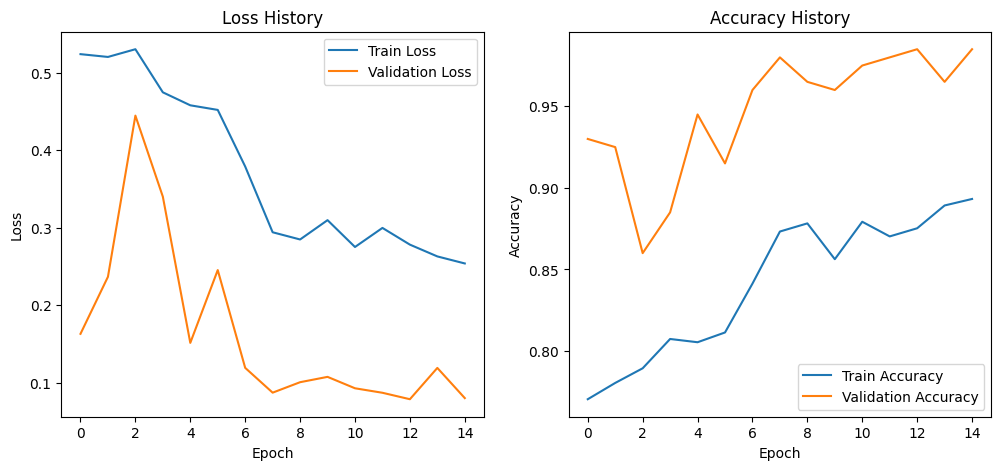

In [4]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=15):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    loss_history = {'train': [], 'val': []}
    acc_history = {'train': [], 'val': []}

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            loss_history[phase].append(epoch_loss)
            acc_history[phase].append(epoch_acc.item())

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    model.load_state_dict(best_model_wts)
    return model, loss_history, acc_history

model_ft = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = model_ft.fc.in_features
model_ft.fc = torch.nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = torch.nn.CrossEntropyLoss()

optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 15
model_ft, loss_hist, acc_hist = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=num_epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(loss_hist['train'], label='Train Loss')
plt.plot(loss_hist['val'], label='Validation Loss')
plt.title("Loss History")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(acc_hist['train'], label='Train Accuracy')
plt.plot(acc_hist['val'], label='Validation Accuracy')
plt.title("Accuracy History")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

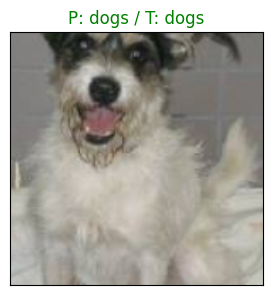

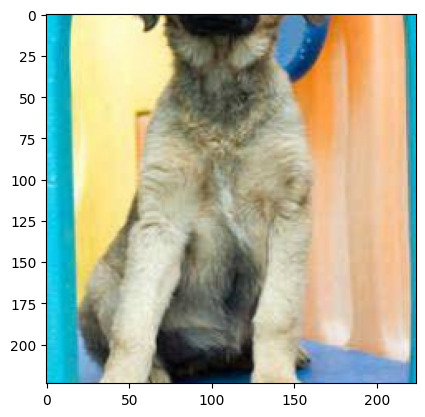

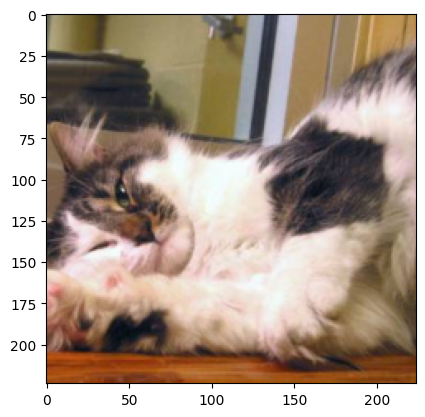

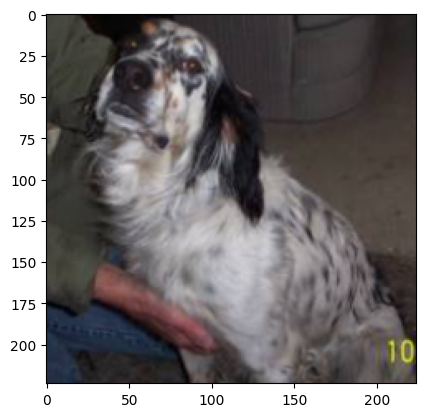

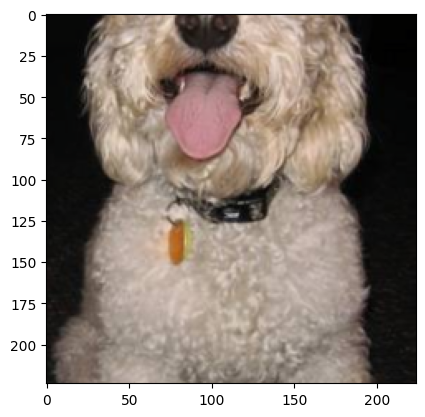

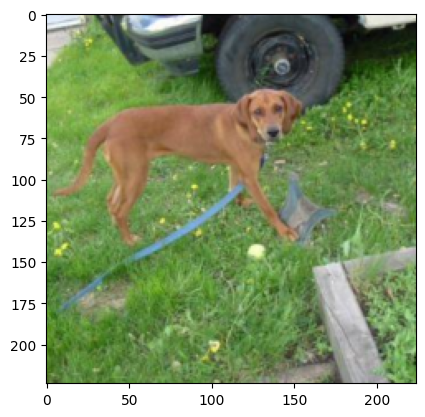

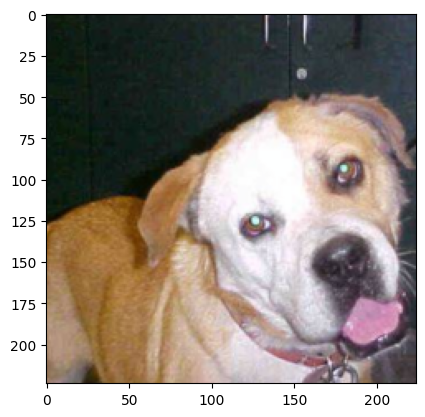

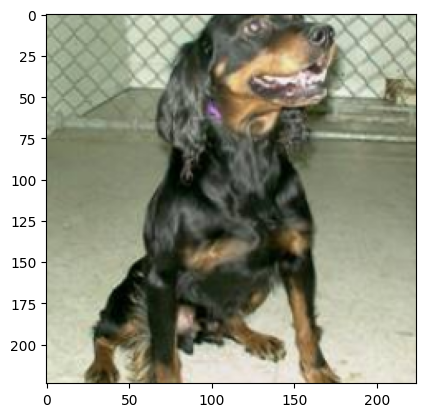

In [5]:
def visualize_model(model, num_images=8):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure(figsize=(15, 8))

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = fig.add_subplot(2, num_images // 2, images_so_far, xticks=[], yticks=[])

                title = f'P: {class_names[preds[j]]} / T: {class_names[labels.data[j]]}'
                ax.set_title(title, color="green" if preds[j] == labels.data[j] else "red")
                imshow(inputs.cpu().data[j], title=None)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model_ft, num_images=8)